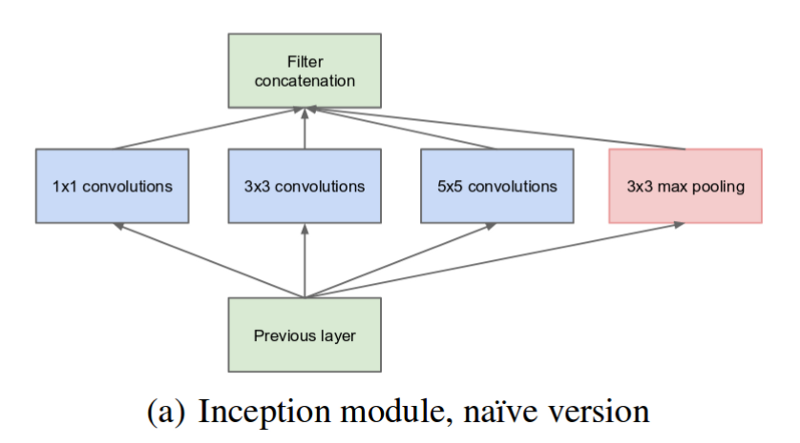

In [1]:
import keras
from keras.layers import Layer
import keras.backend as K
import tensorflow as tf
from keras.datasets import cifar10

from keras.models import Model
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Input, concatenate, GlobalAveragePooling2D, AveragePooling2D, Flatten

import cv2
import numpy as np
from keras.datasets import cifar10
from keras import backend as K
from keras.utils import to_categorical

import math
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler

import matplotlib.pyplot as plt

In [4]:
def inception_module(x,filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj, name=None):
     conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
        
     conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
     conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)
     
     conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
     conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)
    
     pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
     pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)
    
     output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)

     return output

In [5]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

input_layer = Input(shape=(74, 74, 3))

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')


x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(10, activation='softmax', name='auxilliary_output_1')(x1)

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(10, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(10, activation='softmax', name='output')(x)

/opt/conda/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
